<a href="https://colab.research.google.com/github/rushabh-v/AE-4-to-3/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np

import pandas as pd

from sklearn.decomposition import TruncatedSVD

from fastai import basic_train, basic_data
from fastai.basic_data import DatasetType
import fastai

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt


# Load the data

In [37]:
train = pd.read_pickle('/content/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('/content/all_jets_test_4D_100_percent.pkl')

train.head(5)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


# Preprocessing

### Normalization
Make the inputs having `mean` of `0` and `standard deviation`
of `1`. 

This fixes the outliers in the data and makes the learning process much more easier, smoother and faster for the computer.

note: All the data(e.g `train` and `test` data) should be normalized with the same mean and standard deviation.

In [0]:
mean = train.mean()
std = train.std()

train_data = (train - mean) / std
test_data = (test - mean) / std

train_x = train_data
test_x = test_data
train_y = train_x
test_y = test_x

### SVD [(Singular Value Decomposition)](https://en.wikipedia.org/wiki/Singular_value_decomposition)

SVD is a mathematical process(basically metrix operations) to factorize a matrix into a lower dimantion of our choise.

Here, I have specified `n_components=3` below as the lower dimention, as we want to compress our `4` variable tensor into `3` variable tensor.

More details and tutorials on `svd` can be found on Rachel Thomas's(__Fastai's__) __Computational Linear Algebra Course__. [Notebook](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb#Singular-Value-Decomposition-(SVD)) and the [lecture](https://www.youtube.com/watch?v=kgd40iDT8yY&list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY&index=2) can be found in the respective links.


In [0]:
svd = TruncatedSVD(n_components=3)

def add_singular_values(df1):

    df = df1.copy() # make a copy of the data
    sing_vals = []

    # compute and append the singular values into list sing_vals for each data entry
    for i in range(len(df)):
        a = np.diag(df.iloc[i])
        svd.fit(a)
        sing_vals.append(svd.singular_values_)

    # add the singular values into DataFrame
    for i in range(3):
        df.insert(len(df.columns), f'sv_{i}', np.array(sing_vals)[:,i])

    return df


In [0]:
train_df = add_singular_values(train_x)
test_df = add_singular_values(test_x)

In [41]:
train_df.head(5) # sv_0, sv_1 and sv_2 columns in the below DataFrame are respective singular values.

,m,pt,phi,eta,sv_0,sv_1,sv_2
132784,-0.688496,-0.607629,0.868107,0.759040,0.868107,0.759040,0.688496
99666,-0.587358,-0.612672,-1.487534,0.117474,1.487534,0.612672,0.587358
26629,1.051897,1.503479,-1.081401,0.773105,1.503479,1.081401,1.051897
80473,0.788036,1.697702,-0.911068,1.813972,1.813972,1.697702,0.911068
48229,-0.578692,-0.628716,1.619709,-0.830115,1.619709,0.830115,0.628716


In [44]:
train_y.head(5) # here are the respective targets for the above data

,m,pt,phi,eta
132784,-0.688496,-0.607629,0.868107,0.759040
99666,-0.587358,-0.612672,-1.487534,0.117474
26629,1.051897,1.503479,-1.081401,0.773105
80473,0.788036,1.697702,-0.911068,1.813972
48229,-0.578692,-0.628716,1.619709,-0.830115


#Databunch prepration

In [0]:
train_ds = TensorDataset(torch.tensor(train_df.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_df.values).float(), torch.tensor(test_y.values).float())

In [0]:
bs = 1024 # batch size

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [0]:
databunch = basic_data.DataBunch(train_dl, valid_dl)

#Model definaiton

Here I have used a lot of `nn.Linear`, `nn.BatchNorm1d` and `nn.Tanh` layers. Basically `nn.Tanh` is there to add a nonlinearity.

### Why we need to add `non-linearity`?
Because without non-linearity the model would become a bunch of linear functions(layers here) and combination of more than 1 linar function is again a linear function. There are other non-linear functions like `nn.ReLU` as well but `nn.Tenh` turned out to work better in this case when I tested.

### Why we need to use `BatchNorm`?
As we normalize our input data for make the learning process faster, Batchnorm does the same thing for the hidden layers. It normalizes the activations to make the learning faster and easier.

More details about `BatchNorm` and `non-linearities` can be found on Jeremy Howard's (__Fastai's__) __Practical Deep Learning for Coders 2019 course__. _Find the respective lecture_ [here](https://course.fast.ai/videos/?lesson=6).

In [0]:
class Lin_batchnorms_tanh(nn.Module):
    def __init__(self, in_features=7, out_features=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            nn.Linear(200, 500),
            nn.BatchNorm1d(500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.BatchNorm1d(500),
            nn.Tanh(),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 50),
            nn.BatchNorm1d(50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            nn.Linear(200, 500),
            nn.BatchNorm1d(500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.BatchNorm1d(500),
            nn.Tanh(),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            nn.Linear(200, 4)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


# Learner defination

In [0]:
Learner = basic_train.Learner
learn = Learner(db, Lin_batchnorms_tanh(), loss_func=nn.MSELoss(), bn_wd=False, true_wd=True)

# Training

## Find a good learning rate and train

In [98]:
from fastai import train
train.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


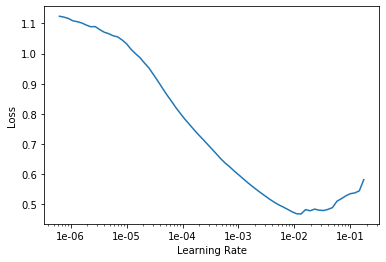

In [99]:
learn.recorder.plot()

#### One cycle training approch

Here I am using the one cycle training approch.


One cycle training policy was a research paper came in _march, 2018_. __It basically makes the learning rate higher and then again lower as the training process goes on__.

_The research paper can be found_ [here](https://arxiv.org/abs/1803.09820).

In [100]:
learn.fit_one_cycle(150, 1e-3, wd=1e-6)

epoch,train_loss,valid_loss,time
0,0.146703,0.115046,00:05
1,0.075202,0.055212,00:04
2,0.047036,0.039672,00:04
3,0.036274,0.033607,00:04
4,0.032941,0.030224,00:04
5,0.030750,0.029033,00:04
6,0.029138,0.027516,00:04
7,0.028476,0.030720,00:04
8,0.026499,0.029208,00:04
9,0.026917,0.025516,00:04


In [0]:
learn.save("AE-7") # save the model

In [0]:
# !mkdir '/content/drive/My Drive/AE-models/'
!cp '/content/models/AE-7.pth' '/content/drive/My Drive/AE-models/' # take a copy on the drive

In [125]:
learn.load("AE-7")

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f3050760ef0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f30507910b8>;

Test: None, model=Lin_batchnorms_tanh(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=500, bias=True)
    (4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=500, out_features=200, bias=True)
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
    (12): Linear(in_features=200, out_features=100, bias=True)
    (13): BatchNorm1d(100,

In [108]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


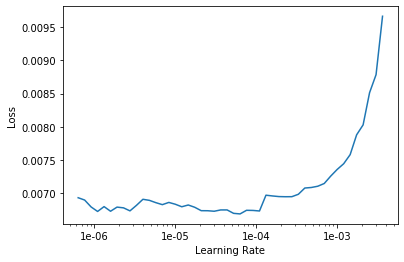

In [109]:
learn.recorder.plot()

The loss is not decreasing on further training. So not saving the model.

In [110]:
learn.fit_one_cycle(100, 1e-7)

epoch,train_loss,valid_loss,time
0,0.006981,0.006295,00:04
1,0.007248,0.006222,00:04
2,0.006917,0.006239,00:04
3,0.006868,0.006116,00:04
4,0.007004,0.006177,00:04
5,0.007004,0.006293,00:04
6,0.006864,0.006103,00:04
7,0.006903,0.006196,00:04
8,0.006854,0.006190,00:04
9,0.006783,0.006139,00:04


KeyboardInterrupt: ignored

In [0]:
learn.save("AE-8") # save the model

In [0]:
!cp '/content/models/AE-8.pth' '/content/drive/My Drive/AE-models/' # take a copy on the drive

# Results

### Predicitons on the test set

In [115]:
learn.get_preds(ds_type=DatasetType.Valid)

[tensor([[-0.5259, -0.5867,  1.0892, -0.0638],
         [-0.4781, -0.5719,  0.5686,  0.4757],
         [-0.4962, -0.5798, -0.6030,  0.5521],
         ...,
         [-0.5387, -0.5455, -1.2283, -1.6014],
         [-0.1429, -0.3979, -1.4853, -0.5979],
         [ 0.0705, -0.2117, -1.0918,  0.3654]]),
 tensor([[-0.5333, -0.5819,  1.0872, -0.0711],
         [-0.4724, -0.6093,  0.5733,  0.4770],
         [-0.4988, -0.5703, -0.6227,  0.5422],
         ...,
         [-0.5517, -0.5617, -1.2107, -1.6051],
         [-0.1767, -0.3924, -1.4821, -0.6032],
         [ 0.0446, -0.1671, -1.1240,  0.3776]])]

In [126]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')


AttributeError: ignored